# Experimenting with possible approaches

In [1]:
!pip install -r requirements.txt

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


## Imports

In [78]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import geopy.distance
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import graphviz

## 1. Data compilation

In [3]:
# assumptions
# source - https://www.icaew.com/insights/viewpoints-on-the-news/2022/sept-2022/chart-of-the-week-energy-price-cap-update
GAS_PRICE_PER_KWH = 3.3
ELECTRIC_PRICE_PER_KWH = 19.0 

In [4]:
# look at the headline dataset of consumption by LSOA
main_data = pd.read_csv("data/LSOA Energy Consumption Data.csv")

In [5]:
main_data.shape

(33811, 21)

In [6]:
main_data['Lower Layer Super Output Area (LSOA) Code'].nunique()

33811

In [7]:
# Library to work with netCDF files
from netCDF4 import Dataset

file_name = "data/tas_hadukgrid_uk_60km_ann_202101-202112.nc"
file_id = Dataset(file_name)

latitude = file_id.variables["latitude"][:,:]
longitude = file_id.variables["longitude"][:,:]
temps = file_id.variables["tas"][:,:]

lats = [np.mean(x) for x in latitude]
longs = [np.mean(x) for x in longitude] 
ts = [np.mean(x) for x in temps[0]]
temp_data = pd.DataFrame({"latitude": lats,
                          "longitude": longs,
                          "temperature": ts}
                        )

temp_data = temp_data[temp_data.temperature > 0]

### Combining and generating features

In [8]:
# feature generation
main_data["pct_electric"] = main_data['Electricity Consumption (kWh)'] / main_data['Total Energy Consumption (kWh)']
main_data["coords"] = [(lat, long) for lat, long in zip(main_data.Latitude, main_data.Longitude)]

df = main_data[['Local Authority Name', 'Local Authority Code', 'MSOA Name',
       'Middle Layer Super Output Area (MSOA) Code', 'LSOA Name',
       'Lower Layer Super Output Area (LSOA) Code', 'coords',
       'pct_electric', 'Average Energy Consumption per Person (kWh)']]

df.columns = ['LA_name', 'LA', 'MSOA_ame',
       'MSOA', 'LSOA_name',
       'LSOA', 'coords',
       'pct_electric', 'energy_consumption_per_person']

In [9]:
list(zip(lats, longs))

[(49.006341737877655, -3.7734278198507476),
 (49.54449813888834, -3.792737447518625),
 (50.082569071478424, -3.812630309295943),
 (50.62055323102576, -3.8331293263161883),
 (51.15844925067594, -3.8542586753822228),
 (51.69625569571884, -3.876043874627027),
 (52.233971057493775, -3.898511876267551),
 (52.77159374677694, -3.9216911671417876),
 (53.309122086599764, -3.945611877796649),
 (53.84655430444121, -3.970305900981369),
 (54.38388852372945, -3.995807020499611),
 (54.92112275458157, -4.022151051484733),
 (55.458254883700604, -4.049375993288645),
 (55.99528266333978, -4.0775221963176405),
 (56.5322036992321, -4.106632544310854),
 (57.06901543737092, -4.136752653741774),
 (57.60571514951215, -4.167931092233809),
 (58.142299917252004, -4.200219618121363),
 (58.6787666145142, -4.233673443562959),
 (59.21511188825929, -4.26835152392834),
 (59.75133213720162, -4.304316876543453),
 (60.2874234882904, -4.34163693229389),
 (60.82338177067651, -4.380383924067725)]

In [10]:
# add temperature data
coords =  [(lat, long) for lat, long in zip(temp_data.latitude, temp_data.longitude)]
temp_dict = {co:t for co,t in zip(coords, temp_data.temperature)}

def find_closest_temp_measurement(this_point):
    return temp_dict[min(temp_dict.keys(), key=lambda x: geopy.distance.geodesic(this_point, x))]

df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]

/tmp/ipykernel_1997/1322134421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]


In [11]:
# compute energy cost
df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]

/tmp/ipykernel_1997/605917991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]


In [12]:
# add income data
income_data = pd.read_csv("data/net_income_after_housing_costs.csv")
income_data = income_data[["MSOA code", "Net annual income after housing costs (£)"]].copy()
income_data.columns = ["MSOA", "net_income"]
df = df.merge(income_data, on="MSOA", how="left")

In [13]:
income_data

,MSOA,net_income
0,E02004297,"27,700"
1,E02004290,"28,600"
2,E02004298,"31,400"
3,E02004299,"25,000"
4,E02004291,"23,800"
...,...,...
7196,W02000362,"29,300"
7197,W02000363,"24,000"
7198,W02000364,"20,300"
7199,W02000365,"21,700"


In [14]:
df.shape

(33811, 12)

In [15]:
# add green data
voting_data = pd.read_csv("data/CBP09228_detailed_results_England_elections.csv")
voting_data["pct_green"] = voting_data["Green"] / voting_data["Total"]
voting_data["green_council"] = voting_data["pct_green"] >= 0.1
voting_data = voting_data[["ONS code", "green_council"]].copy()
voting_data.columns = ["LA", "politically_green"]
df = df.merge(voting_data, on="LA", how="left")

In [16]:
df.shape

(33811, 13)

In [17]:
# add employment status
economic_activity = pd.read_csv("data/economic_activity.csv")
economic_activity = economic_activity[["Area code", "Economically active: \nIn employment \n(including full-time students), \n2021\n(percent)"]]
economic_activity.columns = ["LA", "pct_economically_active"]
df = df.merge(economic_activity, on="LA", how="left")

In [18]:
df.shape

(33811, 14)

In [19]:
# add in home occupancy data
households = pd.read_csv("data/RM202-Household-Size-By-Number-Of-Rooms-2021-lsoa-ONS.csv")
households.rename(columns={"Lower layer Super Output Areas Code": "LSOA"}, inplace=True)
households["pct_home_occupancy"] = households["Household size (5 categories) Code"] / households["Number of rooms (Valuation Office Agency) (6 categories) Code"]
households["pct_home_occupancy_x_obs"] = households["pct_home_occupancy"] * households["Observation"]
households["home_size_x_obs"] = households["Number of rooms (Valuation Office Agency) (6 categories) Code"] * households["Observation"]
totals = households.groupby("LSOA")[["pct_home_occupancy_x_obs", "home_size_x_obs", "Observation"]].sum().reset_index()
totals["home_size"] = totals["home_size_x_obs"] / totals["Observation"]
totals["pct_home_occupancy"] = totals["pct_home_occupancy_x_obs"] / totals["Observation"]
totals = totals[["LSOA", "home_size", "pct_home_occupancy"]]
df = df.merge(totals, on="LSOA", how="left")

In [20]:
df.shape

(33811, 16)

In [21]:
# add in building type - go for pct detatched
buildings1 = pd.read_csv("data/CTSOP_3_1_2021.csv")
buildings1 = buildings1[(buildings1.geography == "LSOA") & (buildings1.band == "All")]
buildings1 = buildings1[["ecode", "bungalow_total", "flat_mais_total", "house_terraced_total",
                         "house_semi_total", "house_detached_total", "all_properties"]]
buildings1 = buildings1.replace("-","0")

# num exposed surfaces
exposed_surfaces_per_type = {
    "bungalow_total": 5,
    "flat_mais_total": 2,
    "house_terraced_total": 3,
    "house_semi_total": 4,
    "house_detached_total": 5
}

buildings1[list(exposed_surfaces_per_type.keys())] = buildings1[exposed_surfaces_per_type.keys()].astype(int)
total_exposed_surfaces = buildings1[list(exposed_surfaces_per_type.keys())].mul(exposed_surfaces_per_type).sum(axis=1)
buildings1["home_exposed_surfaces"]  = [x / int(y) for x,y in zip(total_exposed_surfaces,  buildings1["all_properties"])]
buildings1 = buildings1[["ecode", "home_exposed_surfaces"]]
buildings1.columns = ["LSOA", "home_exposed_surfaces"]

df = df.merge(buildings1, on="LSOA", how="left")

In [22]:
df.shape

(33811, 17)

In [23]:
# add in building age
buildings2 = pd.read_csv("data/CTSOP_4_1_2021.csv")
buildings2 = buildings2[(buildings2.geography == "LSOA") & (buildings2.band == "All")]
buildings2 = buildings2.replace("-","0")

build_dates = {
    'bp_pre_1900': 1900,
    'bp_1900_1918': 1910, 
    'bp_1919_1929': 1925, 
    'bp_1930_1939': 1935, 
    'bp_1945_1954': 1950,
    'bp_1955_1964': 1960, 
    'bp_1965_1972': 1969, 
    'bp_1973_1982': 1978, 
    'bp_1983_1992': 1988,
    'bp_1993_1999': 1996, 
    'bp_2000_2008': 2004, 
    'bp_2009': 2009, 
    'bp_2010': 2010, 
    'bp_2011': 2011,
    'bp_2012': 2012, 
    'bp_2013': 2013, 
    'bp_2014': 2014, 
    'bp_2015': 2015, 
    'bp_2016': 2016, 
    'bp_2017': 2017,
    'bp_2018': 2018,
    'bp_2019': 2019,
    'bp_2020': 2020,
    'bp_2021': 2021,
    'bp_2022_2023': 2021,
    'bp_unkw': 1900 # assume if unknown then likely very old
}

buildings2[list(build_dates.keys())] = buildings2[build_dates.keys()].astype(int)
build_year = buildings2[list(build_dates.keys())].mul(build_dates).sum(axis=1)
totals = buildings2[list(build_dates.keys())].sum(axis=1)
buildings2["home_age"]  = [2021-(x / y) for x,y in zip(build_year,  totals)]
buildings2 = buildings2[["ecode", "home_age"]]
buildings2.columns = ["LSOA", "home_age"]

df = df.merge(buildings2, on="LSOA", how="left")

In [24]:
df.shape

(33811, 18)

In [25]:
# write clean file
df.columns
final_columns = ['LSOA', 'temperature','energy_cost', 'net_income', 'politically_green',
       'pct_economically_active', 'home_size', 'pct_home_occupancy',
       'home_exposed_surfaces', 'home_age', 'energy_consumption_per_person']
df = df[final_columns]
# df.to_csv("compiled_data.csv")

## 2. Analysis and data viz

In [26]:
df = pd.read_csv("compiled_data.csv")
df.shape

# data cleaning
df["politically_green"] = [1 if x == True else 0 for x in df.politically_green]
df["net_income"] = [int(x.replace(",","").strip()) for x in df.net_income]

<Axes: >

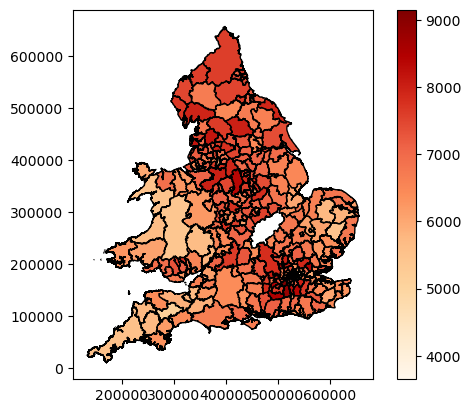

In [27]:
# plot map
las = gpd.GeoDataFrame.from_file("data/LAD_DEC_2021_UK_BFC.shp")
las.rename(columns={"LAD21CD":"LA"}, inplace=True)
df_energy = df.groupby("LA")["energy_consumption_per_person"].mean().reset_index()
las = las.merge(df_energy, on="LA", how="left")
las.plot(column="energy_consumption_per_person", cmap="OrRd", edgecolor="k", legend=True)

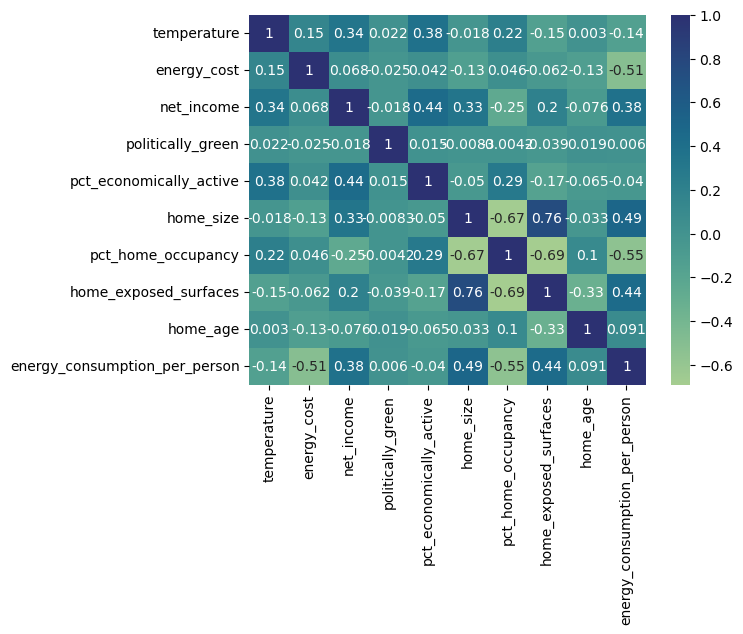

In [28]:
# correlations plot
corr_data = df.drop(columns=['LA', 'MSOA', 'LSOA'], axis=1).corr()
corr_heatmap = sns.heatmap(corr_data, cmap="crest", annot=True) 
corr_heatmap.set(xlabel="", ylabel="")
corr_heatmap.xaxis.tick_bottom()
plt.xticks(rotation=90);

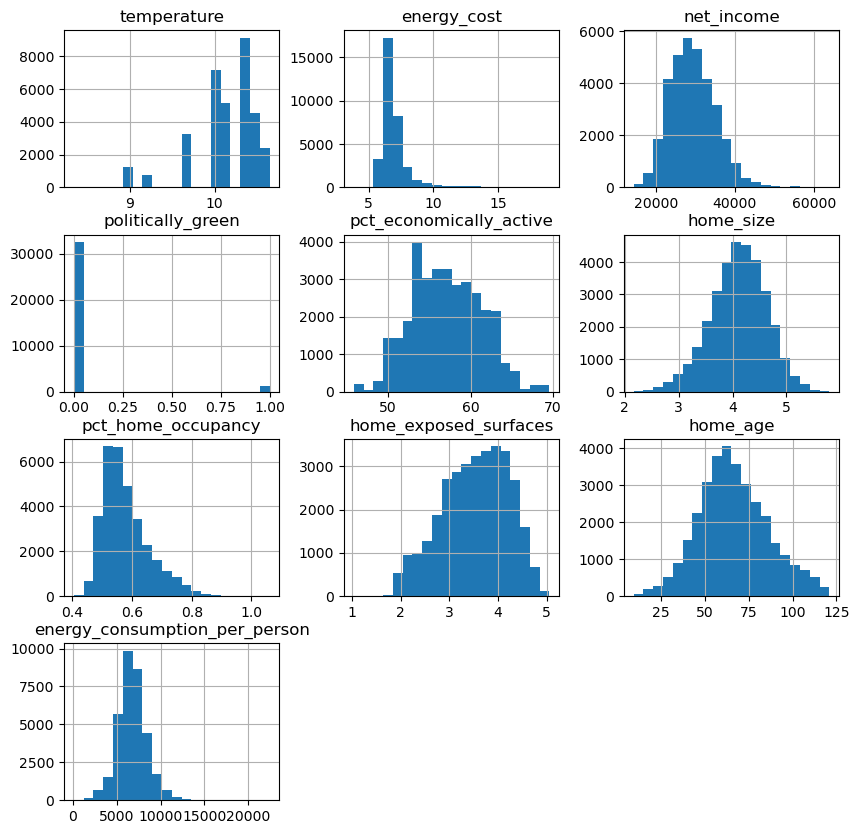

In [29]:
df.hist(bins=20, figsize=(10,10));

## 3. Modelling

In [35]:
# prepare data
model_df = df[['LA', 'politically_green','temperature','energy_cost',
            'net_income','pct_economically_active', 'home_size',
            'pct_home_occupancy', 'home_exposed_surfaces', 'home_age',
            'energy_consumption_per_person']].copy()
# drop any rows with nulls, assumption is that data is missing at random due to merging on LSOA 
model_df.dropna(how='any',axis=0, inplace=True)
model_df["net_income"] = model_df["net_income"].astype(float)
# convert local authority to index variable
model_df['LA'] = model_df['LA'].astype('category').cat.codes

# normalise data, apart from "politically_green" which is binary
scaler = StandardScaler()
scaler.fit(model_df.iloc[:,2:])
model_df.iloc[:,2:] = scaler.transform(model_df.iloc[:,2:])

In [36]:
model_df.shape

(32335, 11)

In [80]:
# model
with pm.Model() as model:
    
    # set uninformative priors for model parameters
    a = pm.Normal('a', 0, 1)
    b_temperature = pm.Normal('b_temperature', 0, 1)
    b_energy_cost = pm.Normal('b_energy_cost', 0, 1)
    b_net_income = pm.Normal('b_net_income', 0, 1)
    b_pct_economically_active = pm.Normal('b_pct_economically_active', 0, 1)
    b_politically_green = pm.Normal('b_politically_green', 0, 1)
    b_home_size = pm.Normal('b_home_size', 0, 1)
    b_pct_home_occupancy = pm.Normal('b_pct_home_occupancy', 0, 1)
    b_home_exposed_surfaces = pm.Normal('b_home_exposed_surfaces', 0, 1)
    b_home_age = pm.Normal('b_home_age', 0, 1)
    
    # set prior for the standard deviation of energy consumption per person
    sigma = pm.Exponential('sigma', 1)
    
    # define mean energy consumption per person as a linear model
    mu = pm.Deterministic('mu', a + 
                          b_politically_green * model_df.politically_green.values + 
                          b_temperature * model_df.temperature.values +
                          b_energy_cost * model_df.energy_cost.values +
                          b_net_income * model_df.net_income.values +
                          b_pct_economically_active * model_df.pct_economically_active.values +
                          b_home_size * model_df.home_size.values +
                          b_pct_home_occupancy * model_df.pct_home_occupancy.values +
                          b_home_exposed_surfaces * model_df.home_exposed_surfaces.values +
                          b_home_age * model_df.home_age.values
                          ) 
    
    likelihood = pm.Normal('likelihood', mu = mu, sigma = sigma, observed = model_df.energy_consumption_per_person.values)

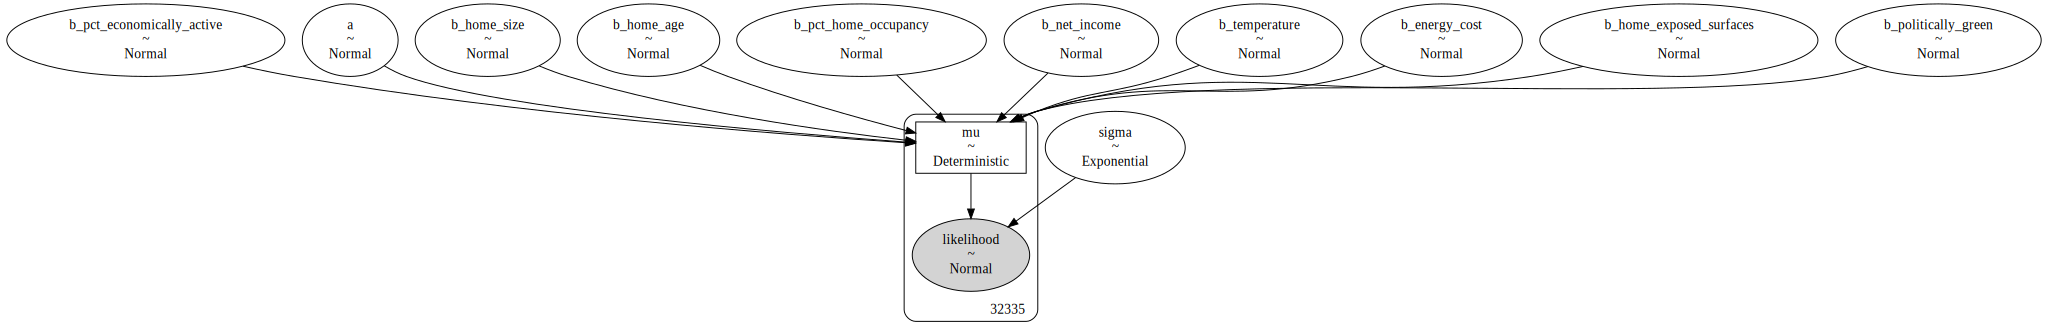

In [81]:
# plot the model
pm.model_to_graphviz(model)

In [82]:
# inference
# sample from posterior
with model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b_politically_green, b_temperature, b_energy_cost, b_net_income, b_pct_economically_active, b_home_size, b_pct_home_occupancy, b_home_exposed_surfaces, b_home_age, sigma]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 115 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


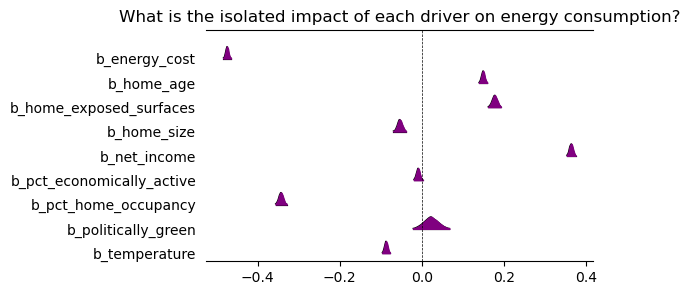

In [87]:
# results
with model:
    az.plot_forest(trace,
                   kind='ridgeplot',
                   filter_vars="regex",
                   var_names=["^b"],
                   hdi_prob=0.99,
                   textsize = 8.0,
                   figsize=(5, 3),
                   colors="purple",
                   combined=True)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.title("What is the isolated impact of each driver on energy consumption?")
plt.figsave("regression_coefficients.png")
plt.close()

In [50]:
# compute r squared
with model:
    predictions = pm.sample_posterior_predictive(trace, model)

Sampling: [likelihood]


Output()

In [68]:
y_samples = predictions["posterior_predictive"].likelihood[0]

In [74]:
y_pred = np.mean(y_samples, axis=0)

In [76]:
y_true = model_df.energy_consumption_per_person.values

In [75]:
len(y_pred)

32335

In [79]:
r2_score(y_true, y_pred)

0.6454877020958822